Loading samples: 100%|██████████| 151/151 [00:14<00:00, 10.43it/s]


Subtitle text:
 now if you could keep your caterwauling down to a minimum i'd like to finish my line of inquiry with young django
screaming resumes man godfuckin'damn it
as i was saying
if you were to see the brittle brothers again you could recognize 'em
yeah
sold american
so mr
speck
mr
speck
how much for young django here


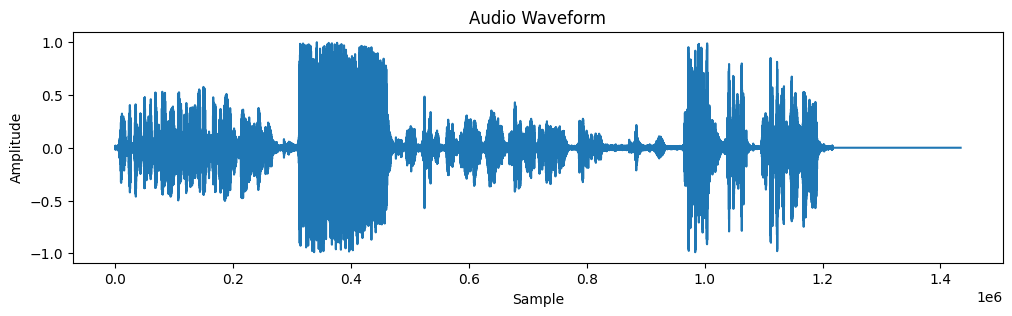

In [1]:
import matplotlib.pyplot as plt
import os
import random
import torch
import torchaudio
import torchaudio.functional as F

from IPython.display import Audio
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import List, Tuple


class MovieSubDataset(Dataset):
    def __init__(self, samples: List[Tuple[str, str]], transform=None, target_transform=None, show_progress: bool =True):
        self.transform = transform
        self.target_transform = target_transform
        self.data = []

        iterator = tqdm(samples, desc="Loading samples") if show_progress else samples

        for wav_path, txt_path in iterator:
            waveform, sample_rate = torchaudio.load(wav_path)
            with open(txt_path, "r", encoding="utf-8") as f:
                subtitle_text = f.read()

            # convert to mono (if stereo) - downmixing
            if waveform.size(0) > 1:
                waveform = waveform.mean(dim=0, keepdim=True)

            # normalize: scale waveform to [-1, 1] range
            waveform = waveform / waveform.abs().max()

            if self.transform:
                waveform = self.transform(waveform)
            if self.target_transform:
                subtitle_text = self.target_transform(subtitle_text)
            
            self.data.append((waveform, sample_rate, subtitle_text))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def collate_fn(batch):
    """Pads both audio and text sequences."""
    waveforms, sample_rates, subtitles = zip(*batch)

    # ensure that waveforms are mono and squeezed correctly to 1D
    waveforms = [w.squeeze(0) if w.size(0) == 1 else w.mean(dim=0, keepdim=True).squeeze(0) for w in waveforms]

    # pad audio waveforms to the same length
    padded_waveforms = pad_sequence(waveforms, batch_first=True)

    return padded_waveforms, sample_rates, subtitles


def load_movie_subs(root_dir: str, batch_size: int = 64) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Load movie subs dataset, split into train/val/test sets, and return corresponding DataLoaders.

    Parameters
    ----------
    root_dir : str
        Path to the dataset directory containing subdirectories for each movie.
    batch_size : int, optional
        Batch size for the DataLoaders. Default is 64.

    Returns
    -------
    Tuple[DataLoader, DataLoader, DataLoader]
        DataLoaders for training, validation, and test datasets.
    """
    all_samples = []

    for movie_name in os.listdir(root_dir):
        movie_path = os.path.join(root_dir, movie_name)
        if not os.path.isdir(movie_path):
            continue

        for fname in os.listdir(movie_path):
            if fname.endswith(".wav"):
                base = os.path.splitext(fname)[0]
                
                wav_path = os.path.join(movie_path, f"{base}.wav")
                txt_path = os.path.join(movie_path, f"{base}.txt")
                
                if os.path.exists(wav_path) and os.path.exists(txt_path):
                    all_samples.append((wav_path, txt_path))

    # shuffle and split
    random.seed(42)
    random.shuffle(all_samples)

    train_data, temp_data = train_test_split(all_samples, test_size=0.3, random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

    # create DataLoaders
    train_loader = DataLoader(MovieSubDataset(train_data), batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(MovieSubDataset(val_data), batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(MovieSubDataset(test_data), batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader, test_loader


def main():
    train_loader, validation_loader, test_loader = load_movie_subs("/kaggle/input/movie2sub-dataset/dataset")

    batch = next(iter(train_loader))
    waveform, sample_rate, subtitle = batch[0][0], batch[1][0], batch[2][0]

    print("Subtitle text:\n", subtitle)

    plt.figure(figsize=(12, 3))
    plt.plot(waveform.numpy())
    plt.title("Audio Waveform")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()
    

if __name__ == "__main__":
    main()